In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import random
import copy

from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 1.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

#numpix = 220 # 60/resolution (for an 1 arcmin wide image)
numpix = 220

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# Color distribution
colors = pd.read_csv('/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/color_distribution/source_colors.csv')
colors = colors[colors['DNF_ZMEAN_MOF'] > 0.01] #When there is no data z<0
colors = colors[colors['MAG_PSF_G'] < 30.] [colors['MAG_PSF_R'] < 30.] [colors['MAG_PSF_I'] < 30.] #decent magnitude
colors['g_r'] = colors['MAG_PSF_G'] - colors['MAG_PSF_R'] # g-r color
colors['r_i'] = colors['MAG_PSF_R'] - colors['MAG_PSF_I'] # r-i color

dz = 0.1 # Range of redshift for filtering
dm = 0.2 # Range of magnitude for filtering

def color_distribution(z, m):
    #objects with a redshift between z - dz and z + dz, same idea for apparent magnitude
    fcolors = colors[(colors['DNF_ZMEAN_MOF'] > z - dz)] [(colors['DNF_ZMEAN_MOF'] < z + dz)] 
    fcolors = fcolors[(colors['MAG_PSF_G'] > m - dm)] [(colors['MAG_PSF_G'] < m + dm)]
    random_object = fcolors.sample()
    g_r = random_object['g_r'].values[0]
    r_i = random_object['r_i'].values[0]
    return(g_r, r_i)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [4]:
def funcion(z_lens, z_source1, z_source2, sigma ,center_lens, center_source1, center_source2, lens_ellip, i):
   
    kwargs_model_physical = {'lens_model_list': ['SIE', 'SHEAR'],  # list of lens models to be used
                          'lens_redshift_list': [z_lens, z_lens],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          'source_redshift_list': [z_source1, z_source2],  # list of redshfits of the sources in same order as source_light_model_list
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source': z_source2} # redshift of the default source (if not further specified by 'source_redshift_list') 
                           #and also serves as the redshift of lensed point sources}

    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)#, kwargs_numerics=kwargs_numerics)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    kwargs_mass = [{'sigma_v': sigma, 'center_x': center_lens[0], 'center_y': center_lens[1], 'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = [sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)[0], {'gamma1': lens_ellip[0], 'gamma2': lens_ellip[1], 'ra_0': 0, 'dec_0': 0}]

    #colors of the other bands for each source
    g_r_source_1, r_i_source_1 = color_distribution(z_source1, 22)
    g_r_source_2, r_i_source_2 = color_distribution(z_source2, 23)
    
    #lens light:
    kwargs_lens_light_mag_g = [{'magnitude': 16, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': lens_ellip[0], 'e2': lens_ellip[1], 'center_x': center_lens[0], 'center_y': center_lens[1]}]
    
    #sources light:
    kwargs_source_mag_g_1 = [{'magnitude': 40, 'R_sersic': 0.3, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': center_source1[0], 'center_y': center_source1[1]}]
    kwargs_source_mag_g_2 = [{'magnitude': 40, 'R_sersic': 0.3, 'n_sersic': 1.5, 'center_x': center_source2[0], 'center_y': center_source2[1]}]
    
    kwargs_source_mag_r_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_r_1[0]['magnitude'] -= g_r_source_1
    
    kwargs_source_mag_r_2 = copy.deepcopy(kwargs_source_mag_g_2)
    kwargs_source_mag_r_2[0]['magnitude'] -= g_r_source_2
    
    kwargs_source_mag_i_1 = copy.deepcopy(kwargs_source_mag_r_1)
    kwargs_source_mag_i_1[0]['magnitude'] -= r_i_source_1
    
    kwargs_source_mag_i_2 = copy.deepcopy(kwargs_source_mag_r_2)
    kwargs_source_mag_i_2[0]['magnitude'] -= r_i_source_2
    
    kwargs_source_mag_g = kwargs_source_mag_g_1 + kwargs_source_mag_g_2
    kwargs_source_mag_r = kwargs_source_mag_r_1 + kwargs_source_mag_r_2
    kwargs_source_mag_i = kwargs_source_mag_i_1 + kwargs_source_mag_i_2
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_g, kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_g)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_g)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    
    plt.figure()
    plt.title('Simulation ' + str(i))
    plt.imshow(rgb)
    plt.xlim(150,0)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig('Image' + str(i) + '.png')
    plt.show(block=True)

In [5]:
df = pd.read_csv ('examples.csv')
df.head()

,COADD ID,Document,G1,G2
0,156608243,ac,-0.302573,0.423090
1,156625245,ac,-0.154100,-0.143544
2,156640371,ac,0.372599,-0.254309
3,154791366,ac,-0.410868,-0.475825
4,230421075,ac,0.116569,-0.583963


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in log10


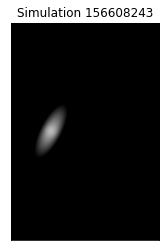

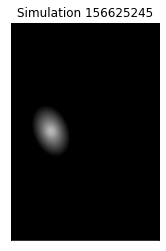

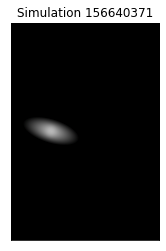

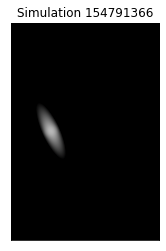

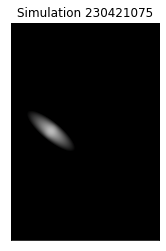

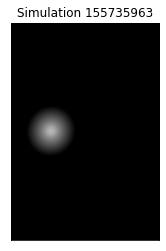

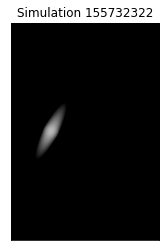

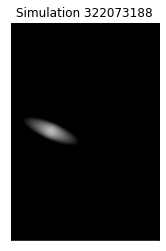

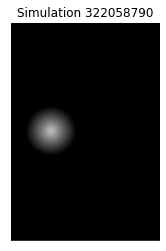

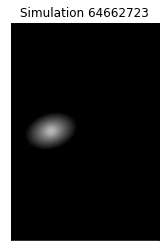

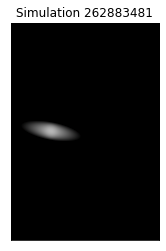

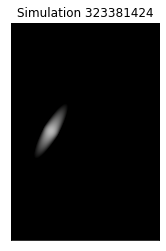

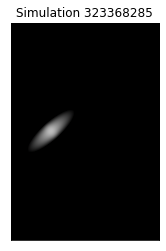

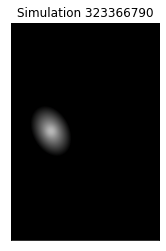

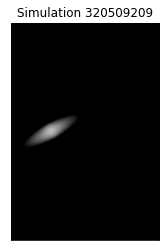

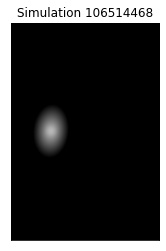

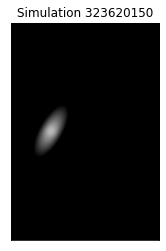

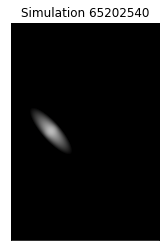

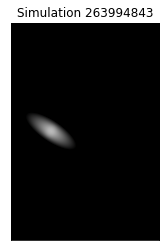

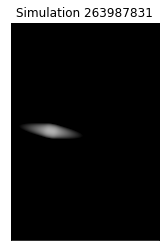

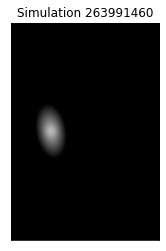

In [6]:
coadd_id = []
for row in df.iterrows():
    zlens = random.uniform(0.01,0.6)
    zsource1 = random.uniform(zlens, 1.2)
    zsource2 = random.uniform(zsource1, 1.3)
    dispersion = random.uniform(300, 700)
    center_lens = [0,0]
    center_source1 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    center_source2 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    lens_ellip = [row[1][2], row[1][3]]
    coadd_id.append(row[1][0])
    funcion(zlens, zsource1, zsource2, dispersion, center_lens, center_source1, center_source2, lens_ellip, row[1][0])

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


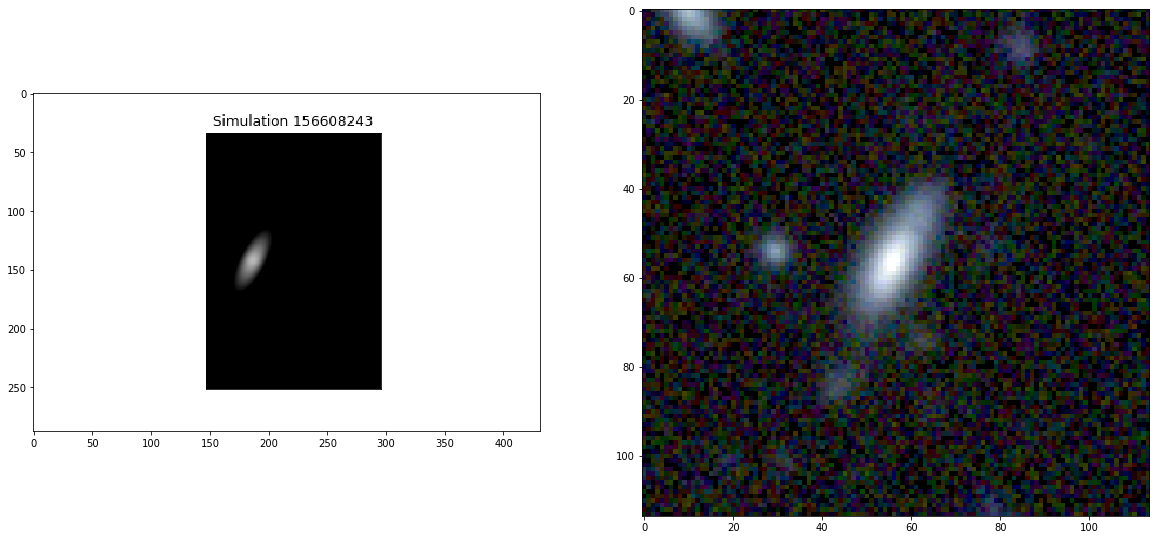

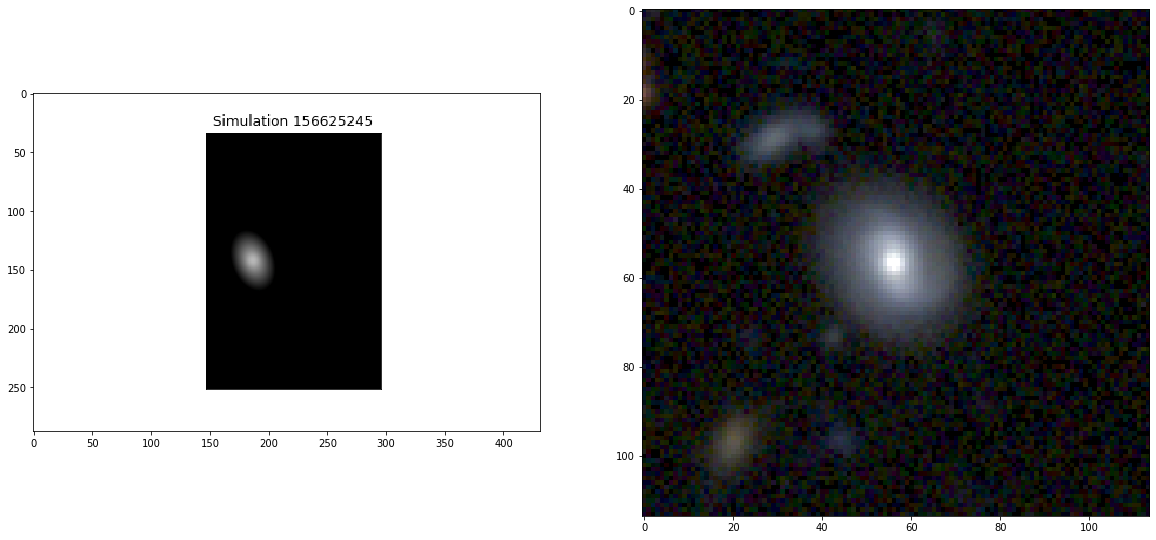

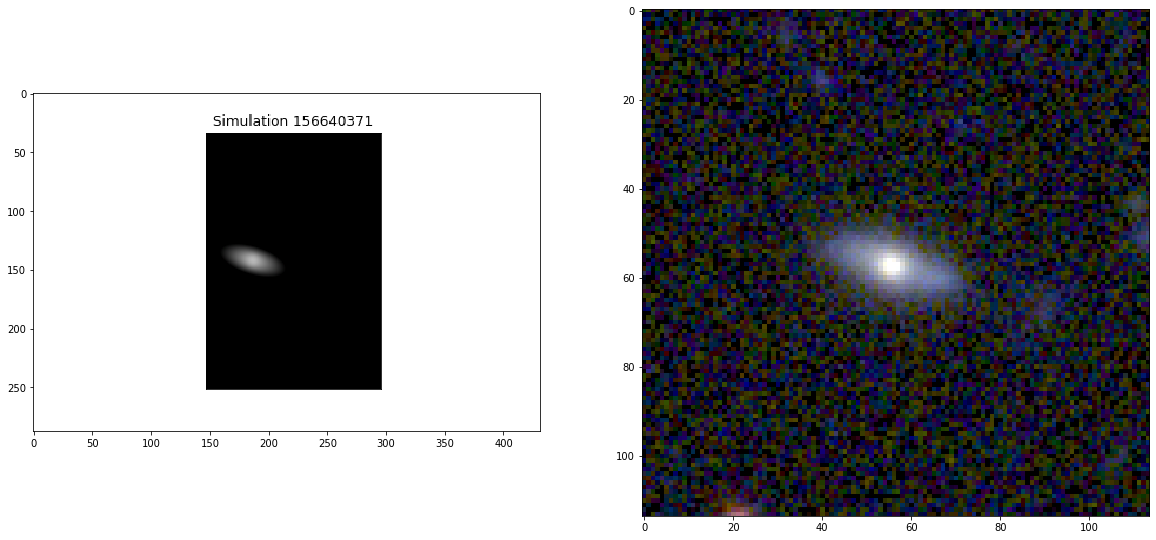

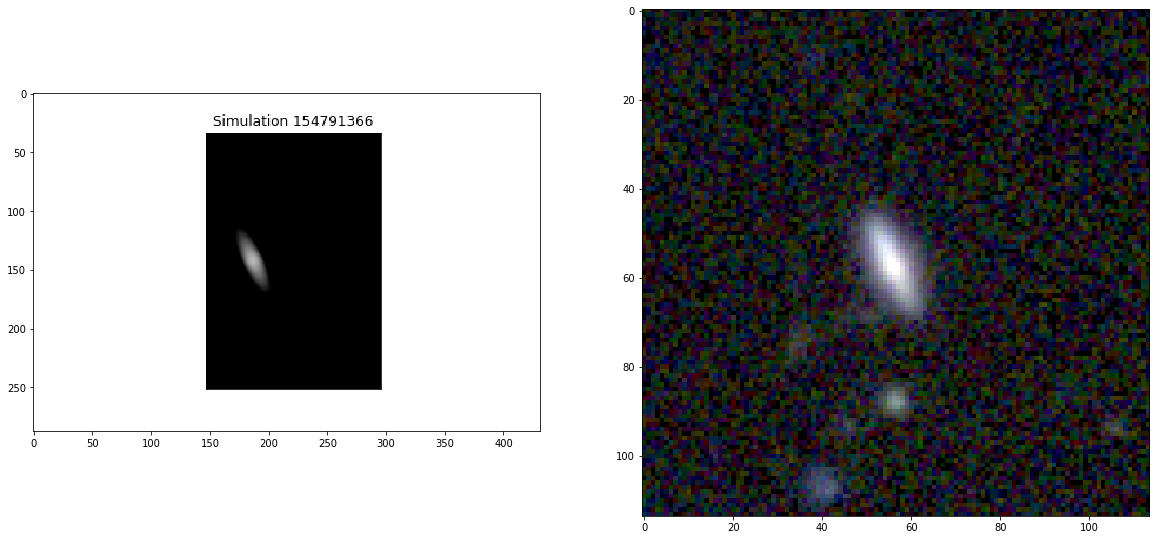

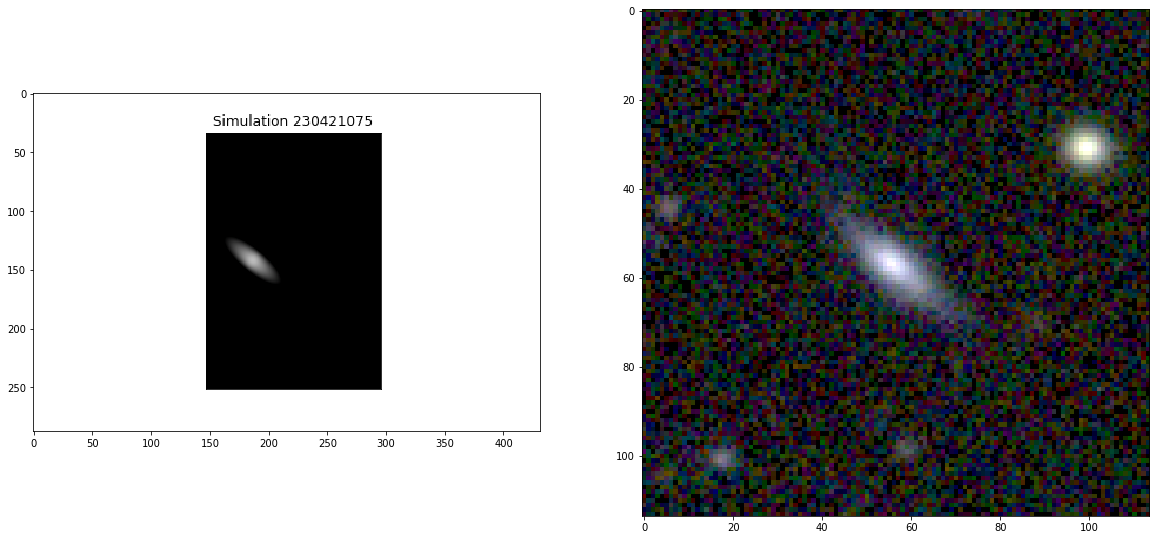

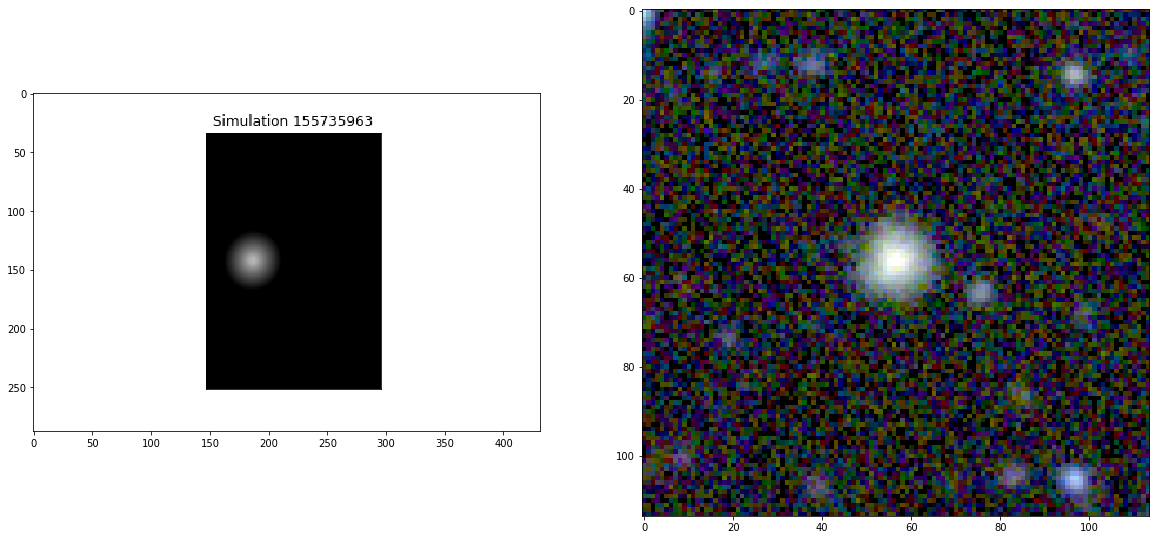

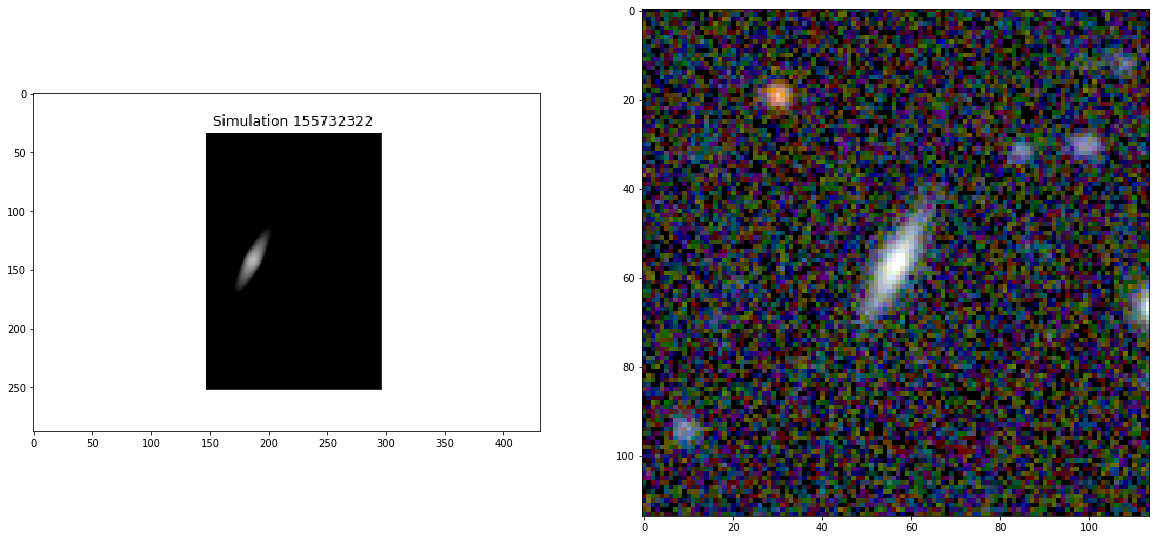

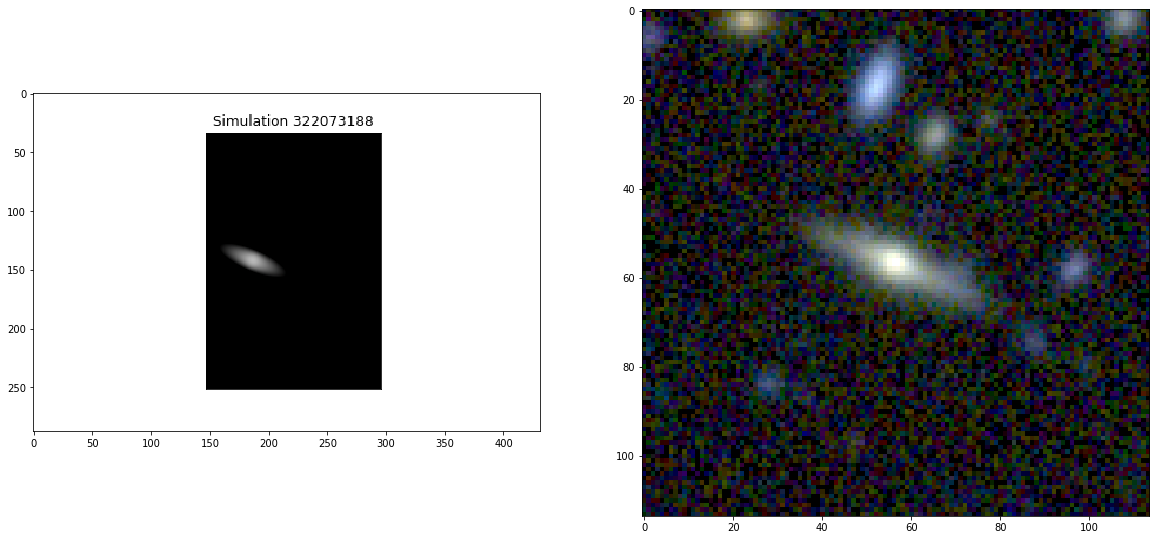

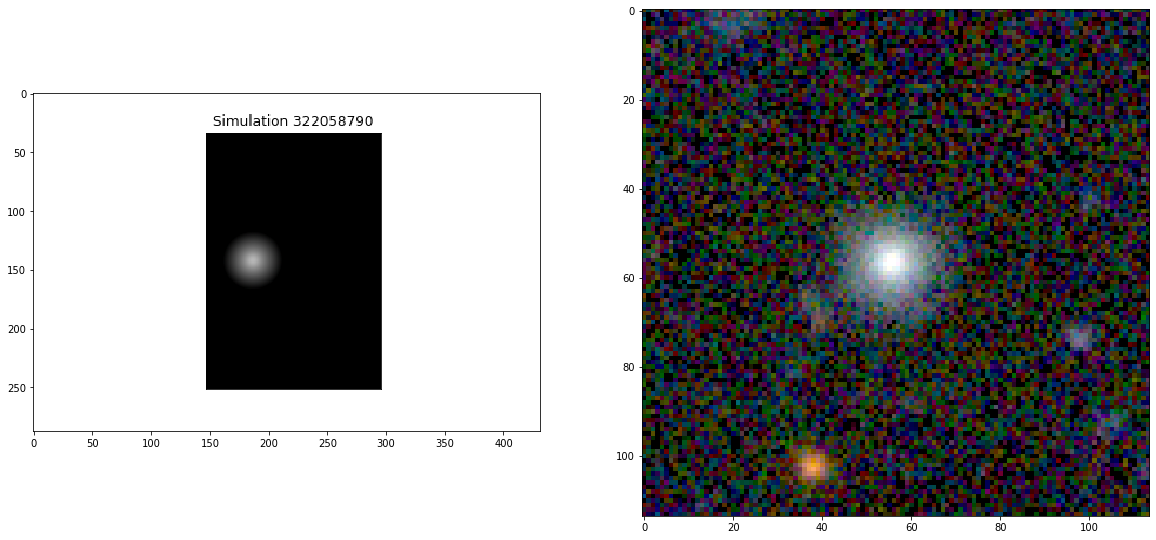

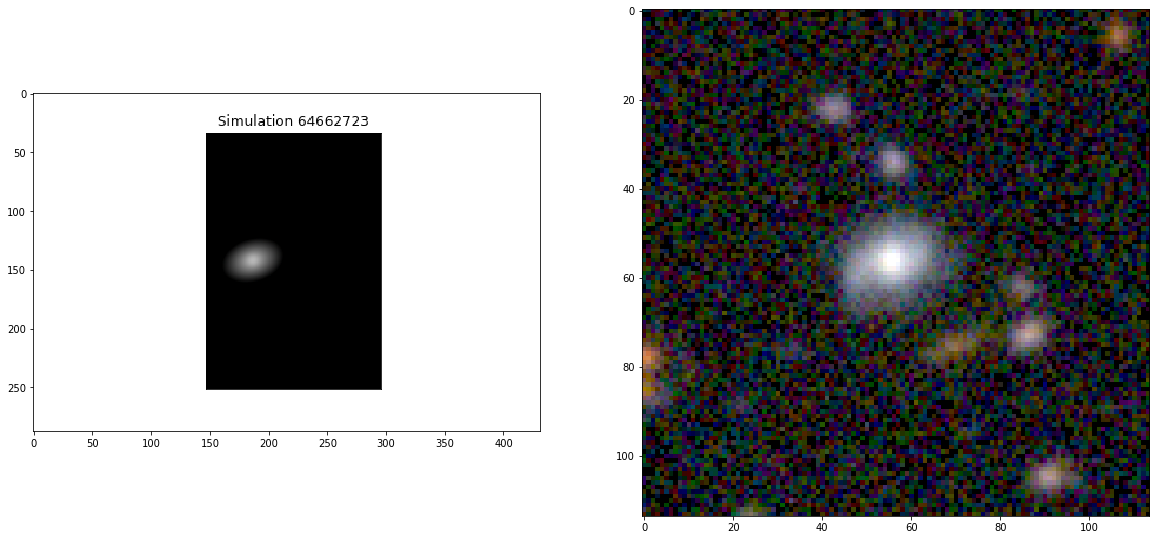

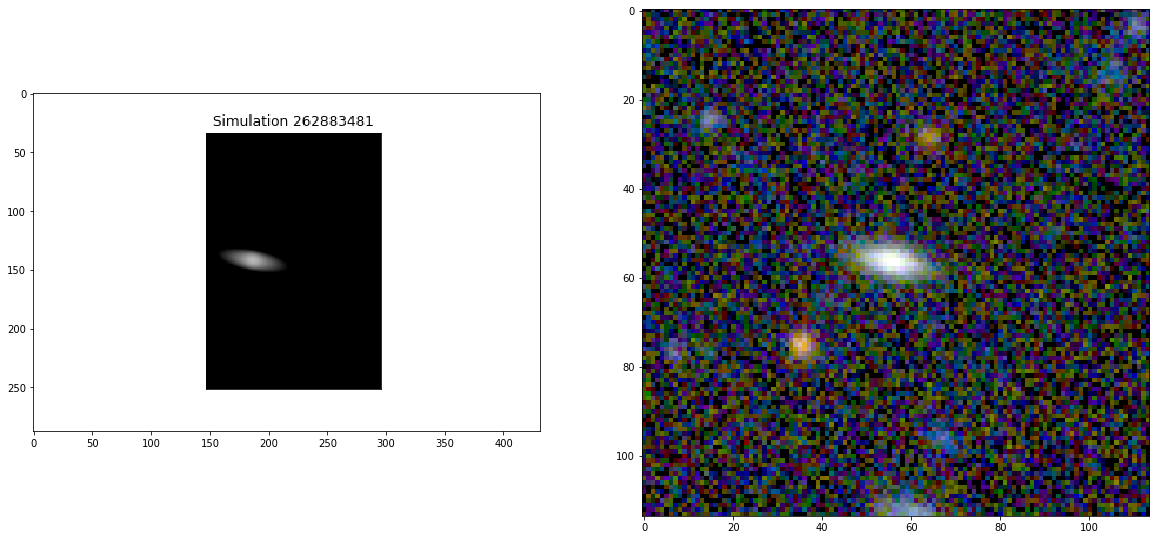

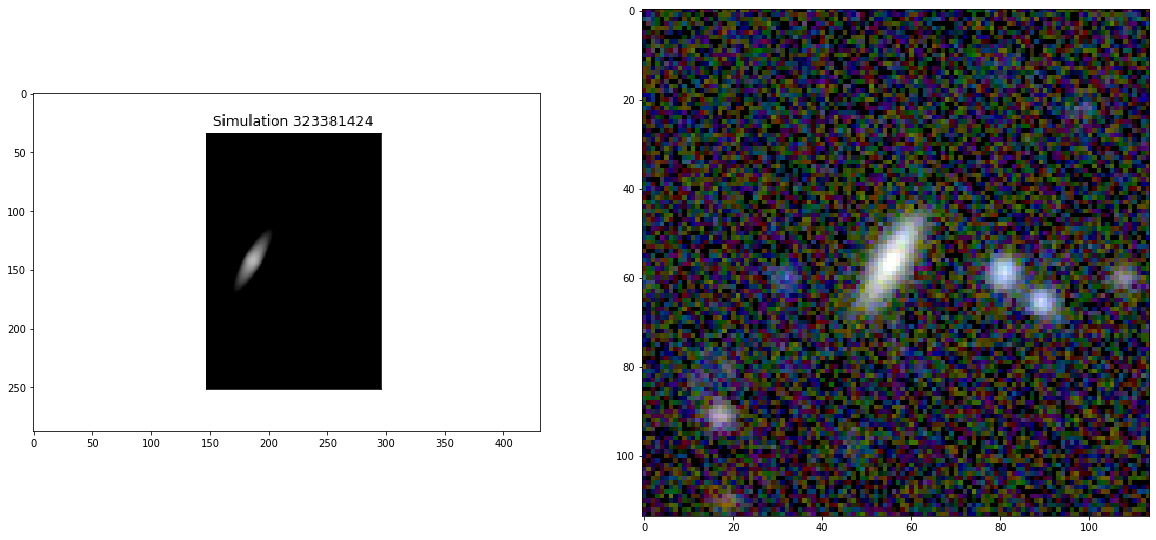

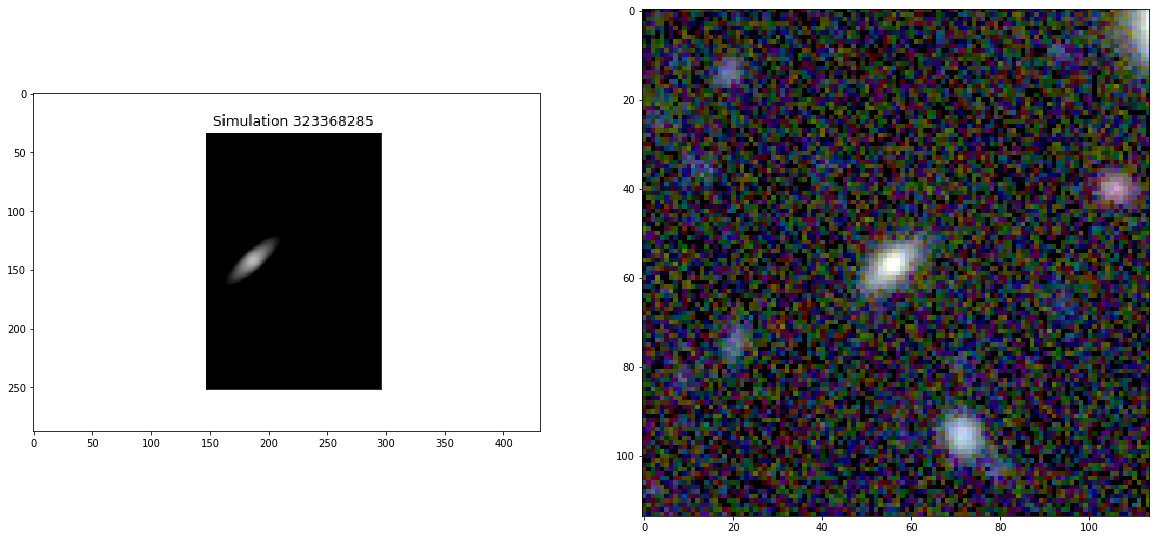

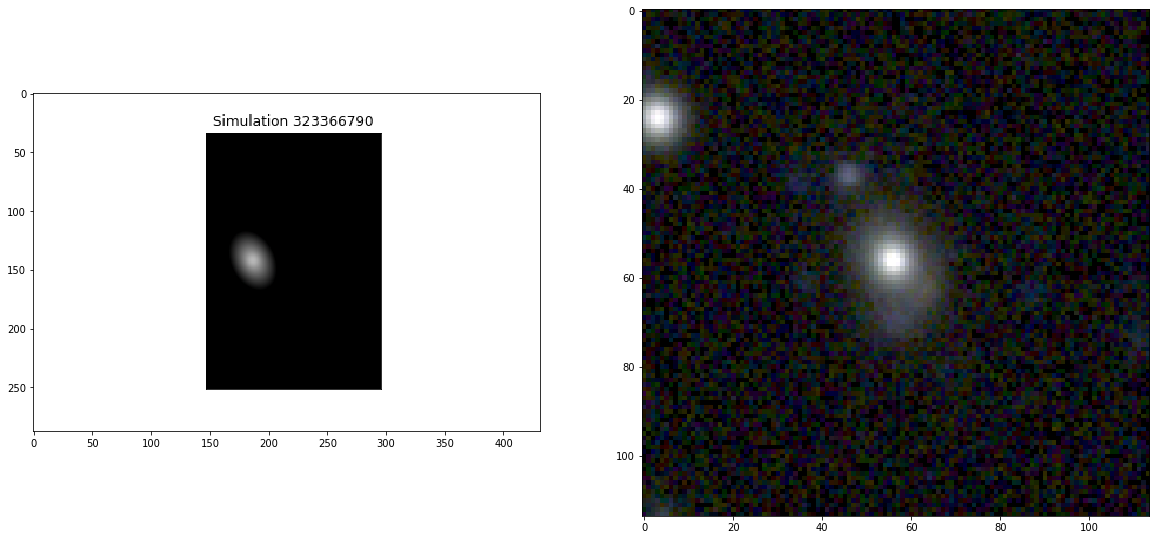

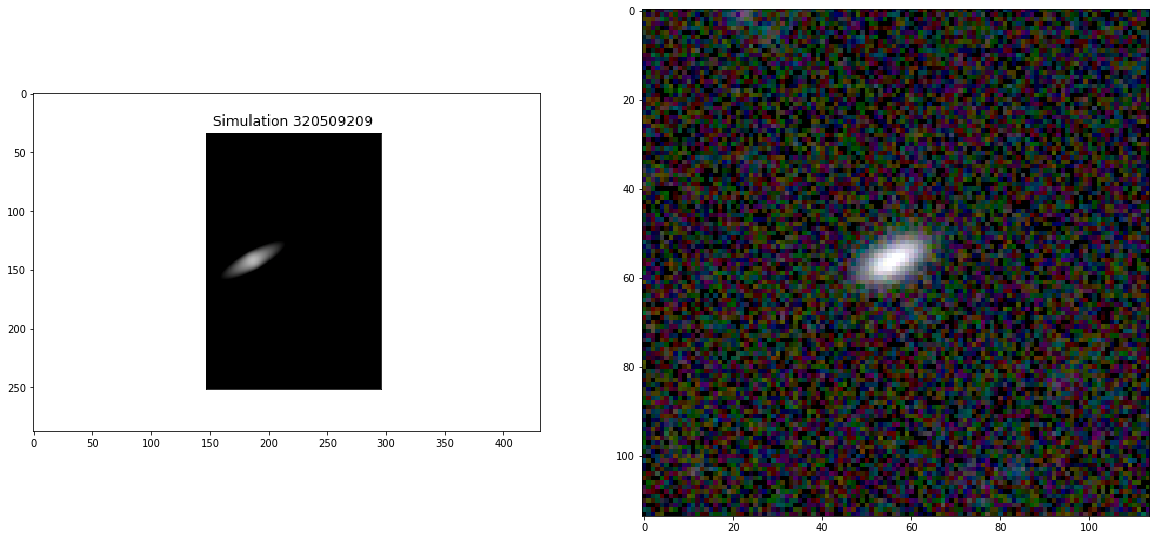

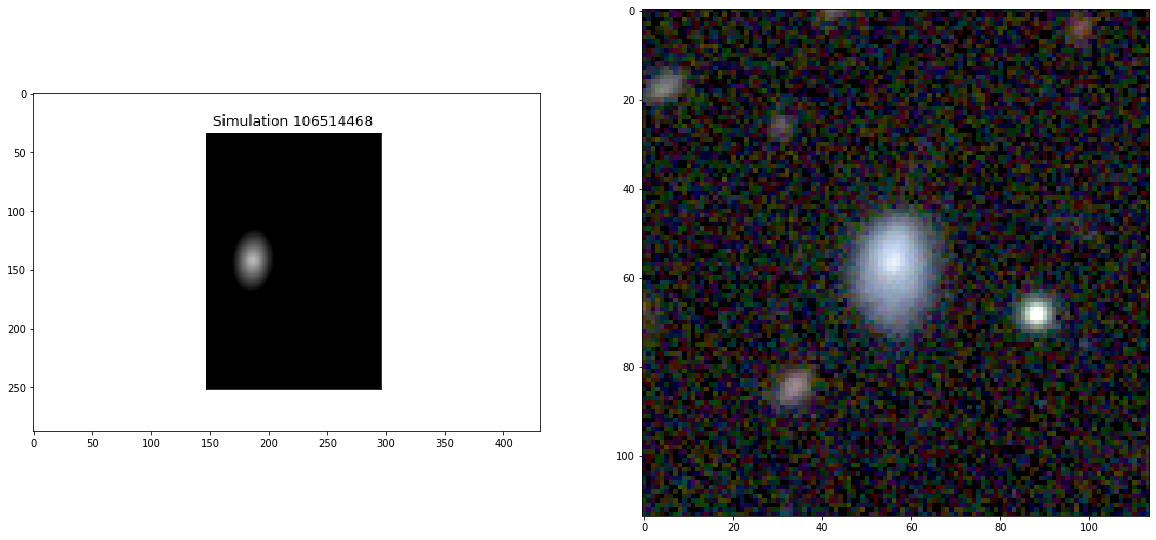

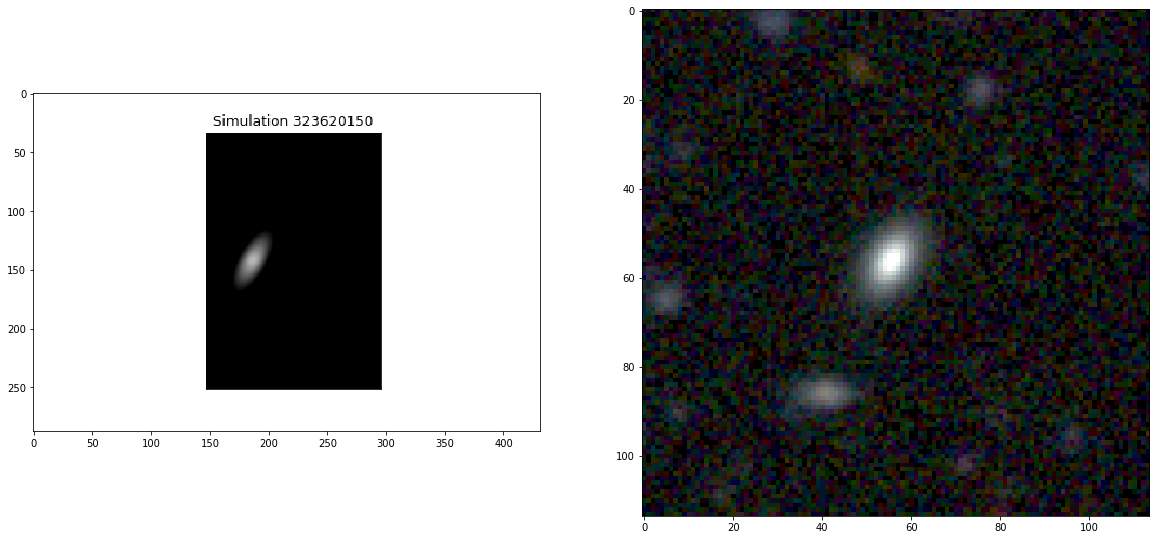

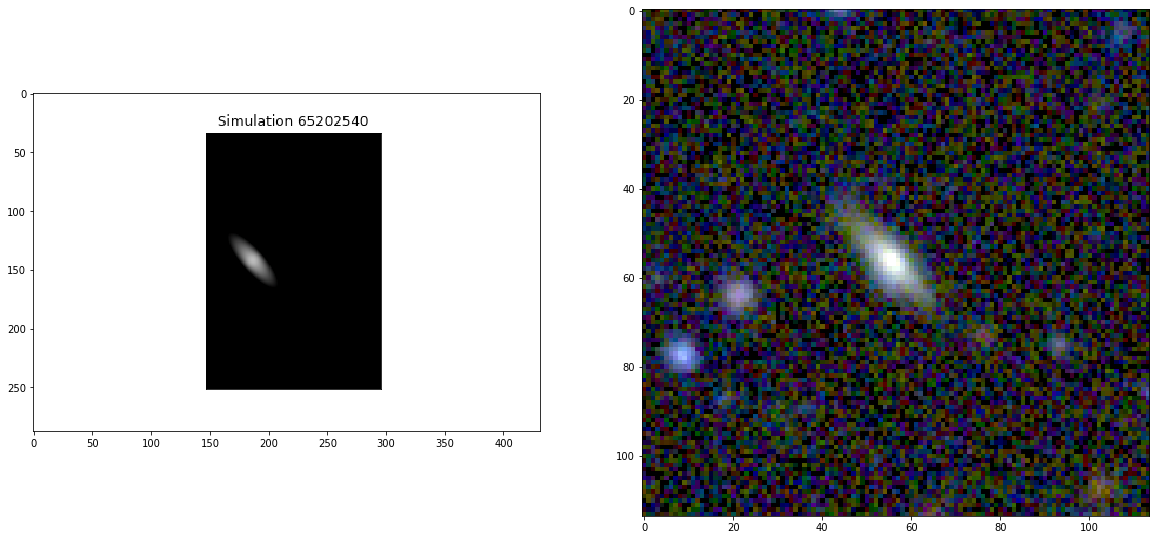

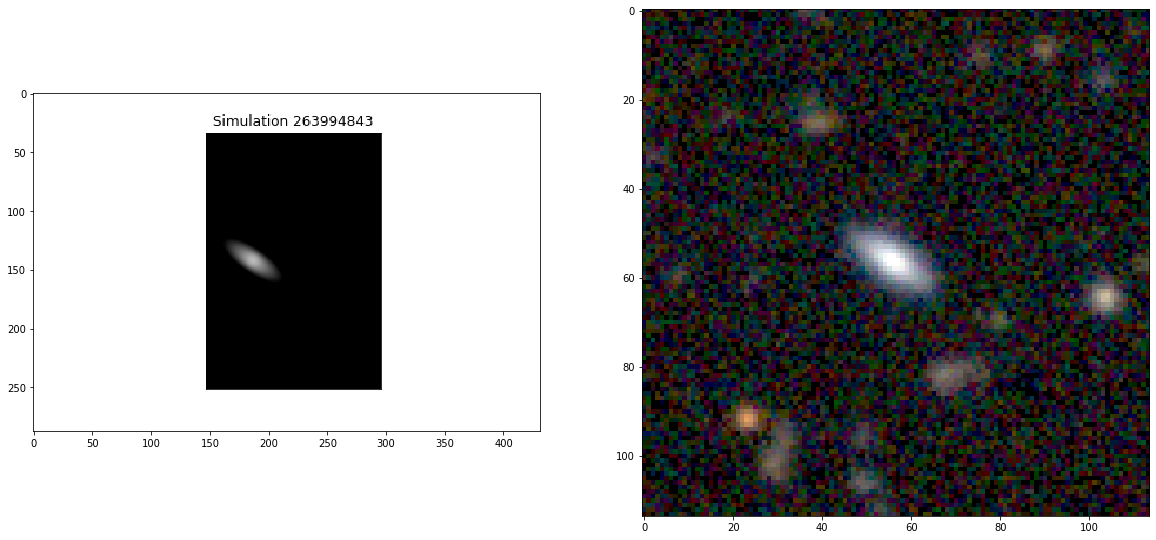

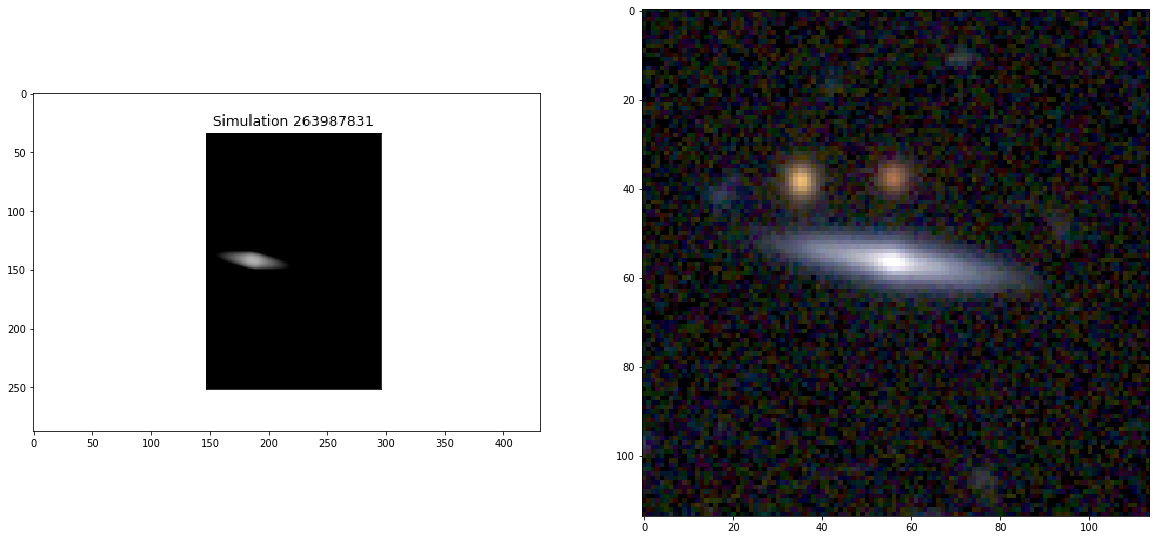

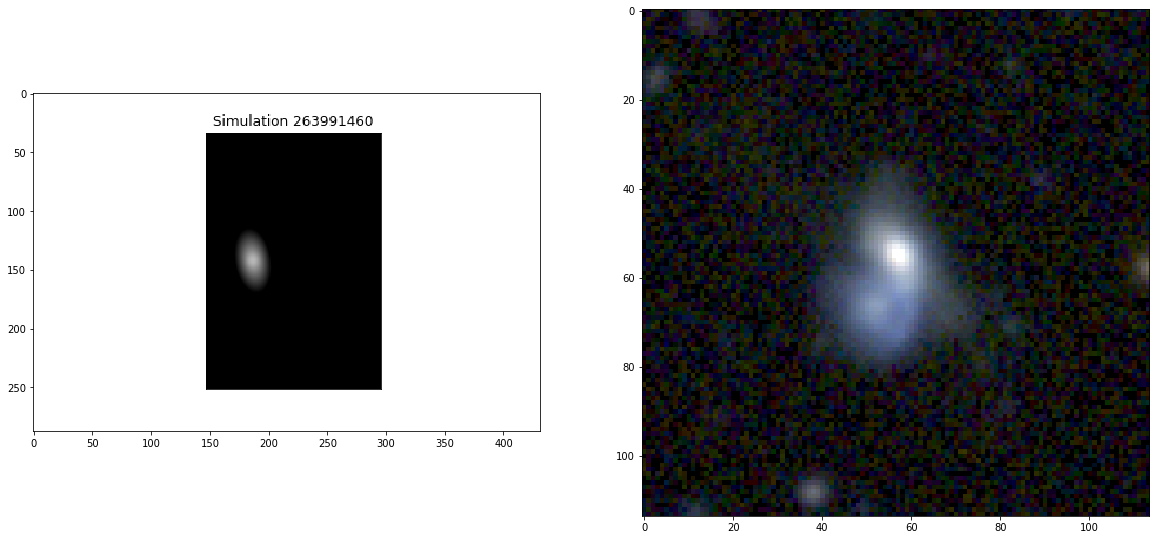

In [7]:
rcParams['figure.figsize'] = 20 ,15

for idc in coadd_id:
    # read images
    img_A = mpimg.imread('Image'+str(idc)+'.png')
    img_B = mpimg.imread('cutouts/'+str(idc)+'_irg_stiff.png')

    # display images
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_A)
    ax[1].imshow(img_B)
    
    plt.savefig('Image' + str(idc) + '.png')

In [8]:
! convert -delay 160 -loop 0 *.png Simulation_vs_real.gif

In [9]:
! rm *.png